# Meal Allowance Optimization: Price, Inflation and Prediction

## **Introduction**

[Employee meal allowances are essential elements of compensation packages](https://www.hubengage.com/employee-experience/significance-and-impact-of-employee-allowances/), directly influencing employee satisfaction and well-being. However, [fluctuating food prices and inflation can challenge the maintenance of their real value](https://www.shrm.org/topics-tools/flagships/all-things-work/the-wage-inflation-challenge----balancing-business-sustainabilit). This project [addresses the need for a data-driven approach to optimize MotorPH's employee meal allowance, ensuring its continued adequacy and relevance](https://business.doordash.com/en-us/resources/research-shows-meal-benefits-improve-employee-satisfaction). By leveraging [historical food price data and economic indicators, the study provides actionable insights and recommendations](https://psa.gov.ph/price-indices/cpi-ir?utm_source=chatgpt.com). The project employs R and Jupyter Lab as powerful tools for data analysis, visualization, and statistical modeling, demonstrating their practical utility in solving real-world business challenges.

## **Objectives**

The primary objectives of this project are as follows:

- To develop a base meal price model using historical food price data from MotorPH's data repository.
- To implement an inflation-adjusted meal allowance model using the Consumer Price Index (CPI) and a proxy Cost of Living Adjustment (COLA).
- To create a predictive model to forecast future meal costs, enabling proactive budgeting.
- To provide data-driven recommendations for optimizing MotorPH's employee meal allowance.

**Data Cleaning and Preparation**
- Main Dataset: [Food Prices](https://github.com/imperionite/insighted/blob/main/DataCleaning_FoodPrices.ipynb)
- Supplementary Dataset: [Employees Record](https://github.com/imperionite/insighted/blob/main/DataCleaning_Employees.ipynb)

In [34]:
# Load Libraries
library(ggplot2)
library(dplyr)
library(lubridate) 
library(RColorBrewer)
library(viridis)
library(tidyr)  
library(treemap)
library(gridExtra)

In [35]:
options(repr.plot.width = 14, repr.plot.height = 11)
# Load CSV
food_prices <- read.csv("food_prices_ph_cleaned.csv", stringsAsFactors = TRUE)
employees <- read.csv("employees_details_cleaned.csv", stringsAsFactors = TRUE)

# Convert Date to date format
food_prices$Date <- as.Date(food_prices$Date)

# Ensure that numeric columns are properly formatted
food_prices$Price <- as.numeric(food_prices$Price)

# Extract year
food_prices$Year <- year(food_prices$Date)


# Filter for dates from 2019 onwards and exclude Unit entries
food_prices <- food_prices %>%
  filter(year(Date) >= 2019, Unit != "Unit")


# Exclude Unit entries
food_prices <- food_prices %>%
  filter(Unit != "Unit")


### Option 1: Meal Price Model Development

#### Category Assignment & Unit Price Calculation

In [36]:
# Ingredient categories
ingredient_categories <- list(
  protein = c("Meat (pork)", "Meat (beef, chops with bones)", "Meat (chicken, whole)", "Fish (fresh)", "Fish (frigate tuna)", "Fish (mackerel, fresh)", "Fish (tilapia)", "Fish (roundscad)", "Fish (slipmouth)", "Fish (threadfin bream)", "Beans (mung)", "Groundnuts (unshelled)", "Groundnuts (shelled)", "Eggs", "Eggs (duck)", "Meat (pork, with bones)", "Meat (beef)", "Meat (pork, hock)", "Meat (pork, with fat)", "Shrimp (endeavor)", "Shrimp (tiger)", "Crab", "Fish (redbelly yellowtail fusilier)", "Fish (milkfish)"),
  carbohydrate = c("Rice (milled, superior)", "Rice (regular, milled)", "Rice (premium)", "Rice (special)", "Rice (well milled)", "Maize flour (yellow)", "Maize flour (white)", "Maize (yellow)", "Maize (white)", "Potatoes (Irish)", "Sweet potatoes", "Semolina (white)", "Semolina (yellow)", "Taro"),
  vegetables = c("Cabbage", "Cabbage (chinese)", "Carrots", "Garlic", "Onions (red)", "Onions (white)", "Tomatoes", "Eggplants", "Bitter melon", "Bottle gourd", "Choko", "Water spinach", "Sweet Potato leaves", "Choko", "Water spinach"),
  fruits = c("Bananas (latundan)", "Bananas (saba)", "Bananas (lakatan)", "Mangoes (carabao)", "Mangoes (piko)", "Pineapples", "Coconut"),
  oils_and_condiments = c("Oil (cooking)", "Sugar (brown)", "Sugar (white)", "Garlic (large)", "Garlic (small)", "Ginger", "Calamansi", "Anchovies")
)

# Category assignment
food_prices$Category <- sapply(food_prices$Commodity, function(x) {
  if (x %in% ingredient_categories$protein) return("Protein")
  if (x %in% ingredient_categories$carbohydrate) return("Carbohydrate")
  if (x %in% ingredient_categories$vegetables) return("Vegetable")
  if (x %in% ingredient_categories$fruits) return("Fruit")
  if (x %in% ingredient_categories$oils_and_condiments) return("Oils and Condiments")
  return("Other")
})

# Unit price calculation (per kg)
food_prices <- food_prices %>%
  mutate(UnitPrice_kg = ifelse(Unit == "750 ML" & Commodity == "Oil (cooking)", Price / (0.75 * 0.92),
                               ifelse(Unit == "KG", Price, NA))) %>%
  filter(!is.na(UnitPrice_kg)) # Remove rows where UnitPrice_kg is NA

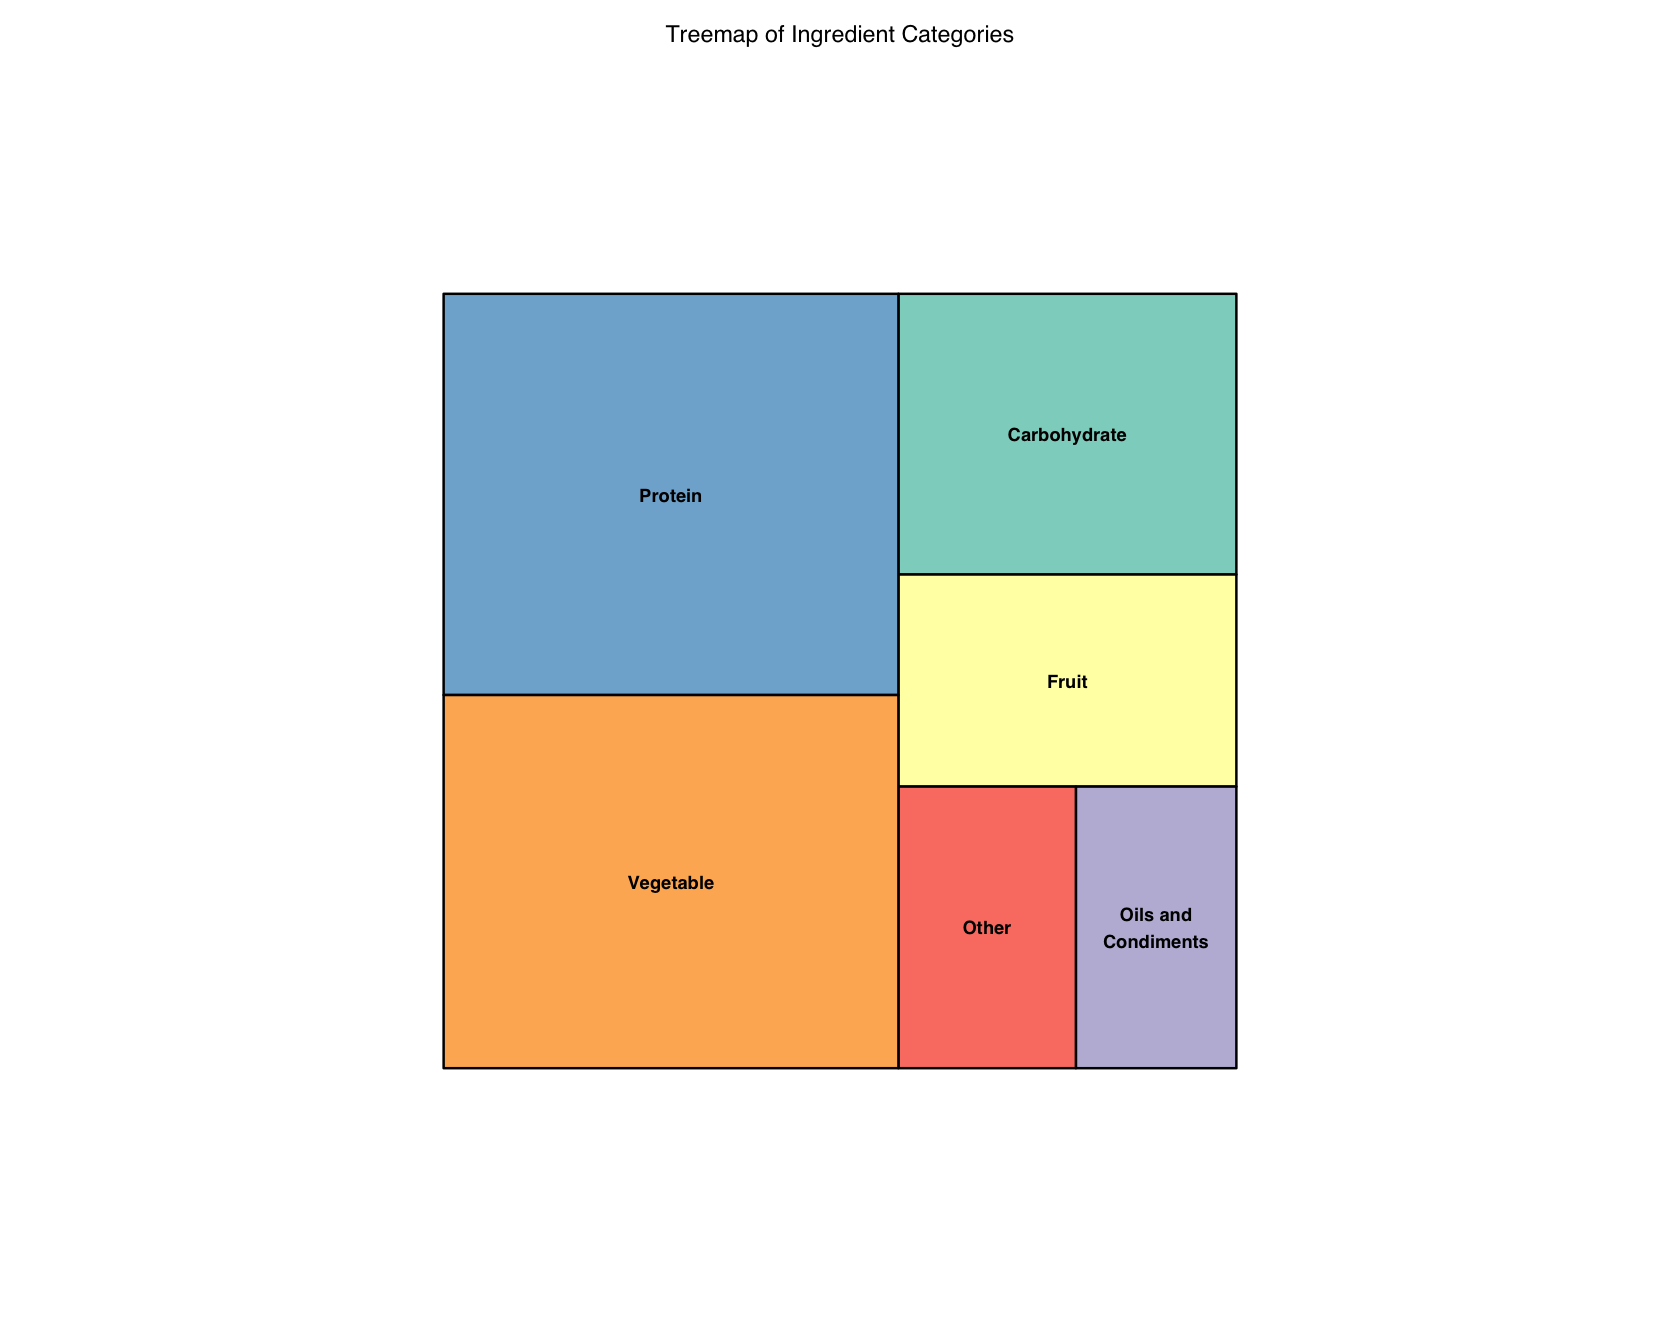

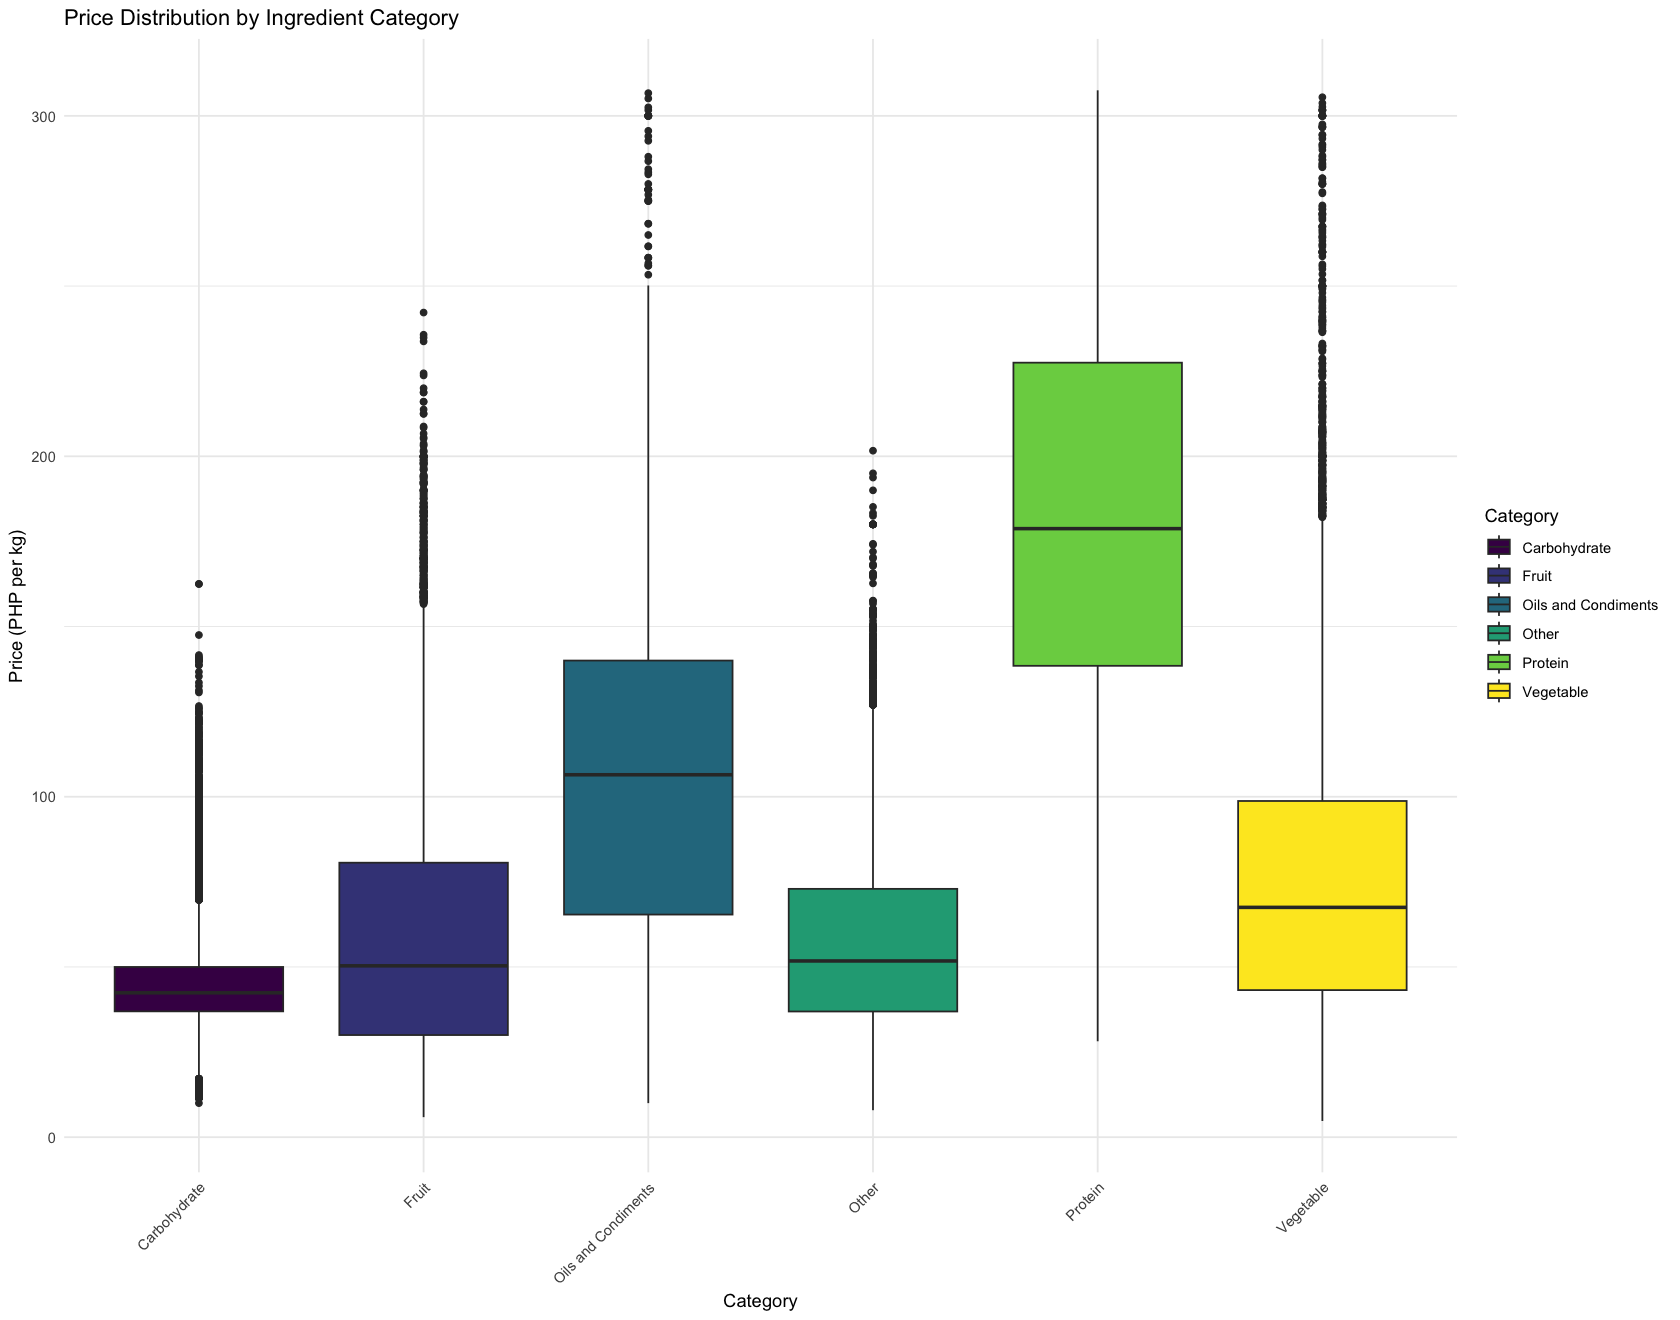

In [37]:
# Treemap: Visual breakdown of ingredient categories
category_size <- food_prices %>%
  count(Category)

treemap(category_size,
        index = "Category",
        vSize = "n",
        title = "Treemap of Ingredient Categories",
        palette = "Set3")

## Boxplot: Price distribution by category
ggplot(food_prices, aes(x = Category, y = UnitPrice_kg, fill = Category)) +
  geom_boxplot() +
  scale_fill_viridis_d() +
  theme_minimal() +
  labs(title = "Price Distribution by Ingredient Category",
       x = "Category", y = "Price (PHP per kg)",
       fill = "Category") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


**TreeMap: Visual Breakdown of Ingredient Categories**  

The treemap provides a clear and intuitive visual representation of the relative size of each ingredient category based on the number of commodities included. Each rectangle represents a category, and the size of the rectangle reflects the number of items assigned to that category. From this visualization, we can observe that the **Protein** category occupies the largest space, indicating that it has the highest variety of items, such as different types of meat, fish, and eggs. This suggests a broad diversity of protein sources in the dataset.  

**Vegetables** also make up a significant portion, demonstrating the wide range of plant-based food items. **Carbohydrates**, **Fruits**, and **Oils and Condiments** are relatively smaller categories, indicating fewer distinct commodities in these groups. The distinct coloring from the "Set3" palette makes it easy to differentiate between the categories, offering an at-a-glance understanding of the composition of food types in the dataset.  

**Boxplot: Price Distribution by Category**  

The boxplot provides a statistical summary of the price distribution for each ingredient category in terms of unit price (PHP per kg). It reveals the spread, central tendency, and potential outliers within each category.  

- **Protein** shows the widest spread in price, with a high interquartile range and several outliers at the higher end, likely reflecting the variety in types of meat and seafood, which have varying market prices.  
- **Carbohydrates** have relatively lower and more consistent prices, with a smaller spread and fewer extreme values, which aligns with staple food items like rice and maize typically having stable pricing.  
- **Vegetables** show moderate price variability, likely reflecting differences in availability and perishability across different vegetable types.  
- **Fruits** display a tighter price range but with some high-end outliers, suggesting occasional spikes for premium fruits like mangoes or seasonal factors affecting pricing.  
- **Oils and Condiments** have the smallest spread and generally lower prices, consistent with essential but lower-cost cooking ingredients.  

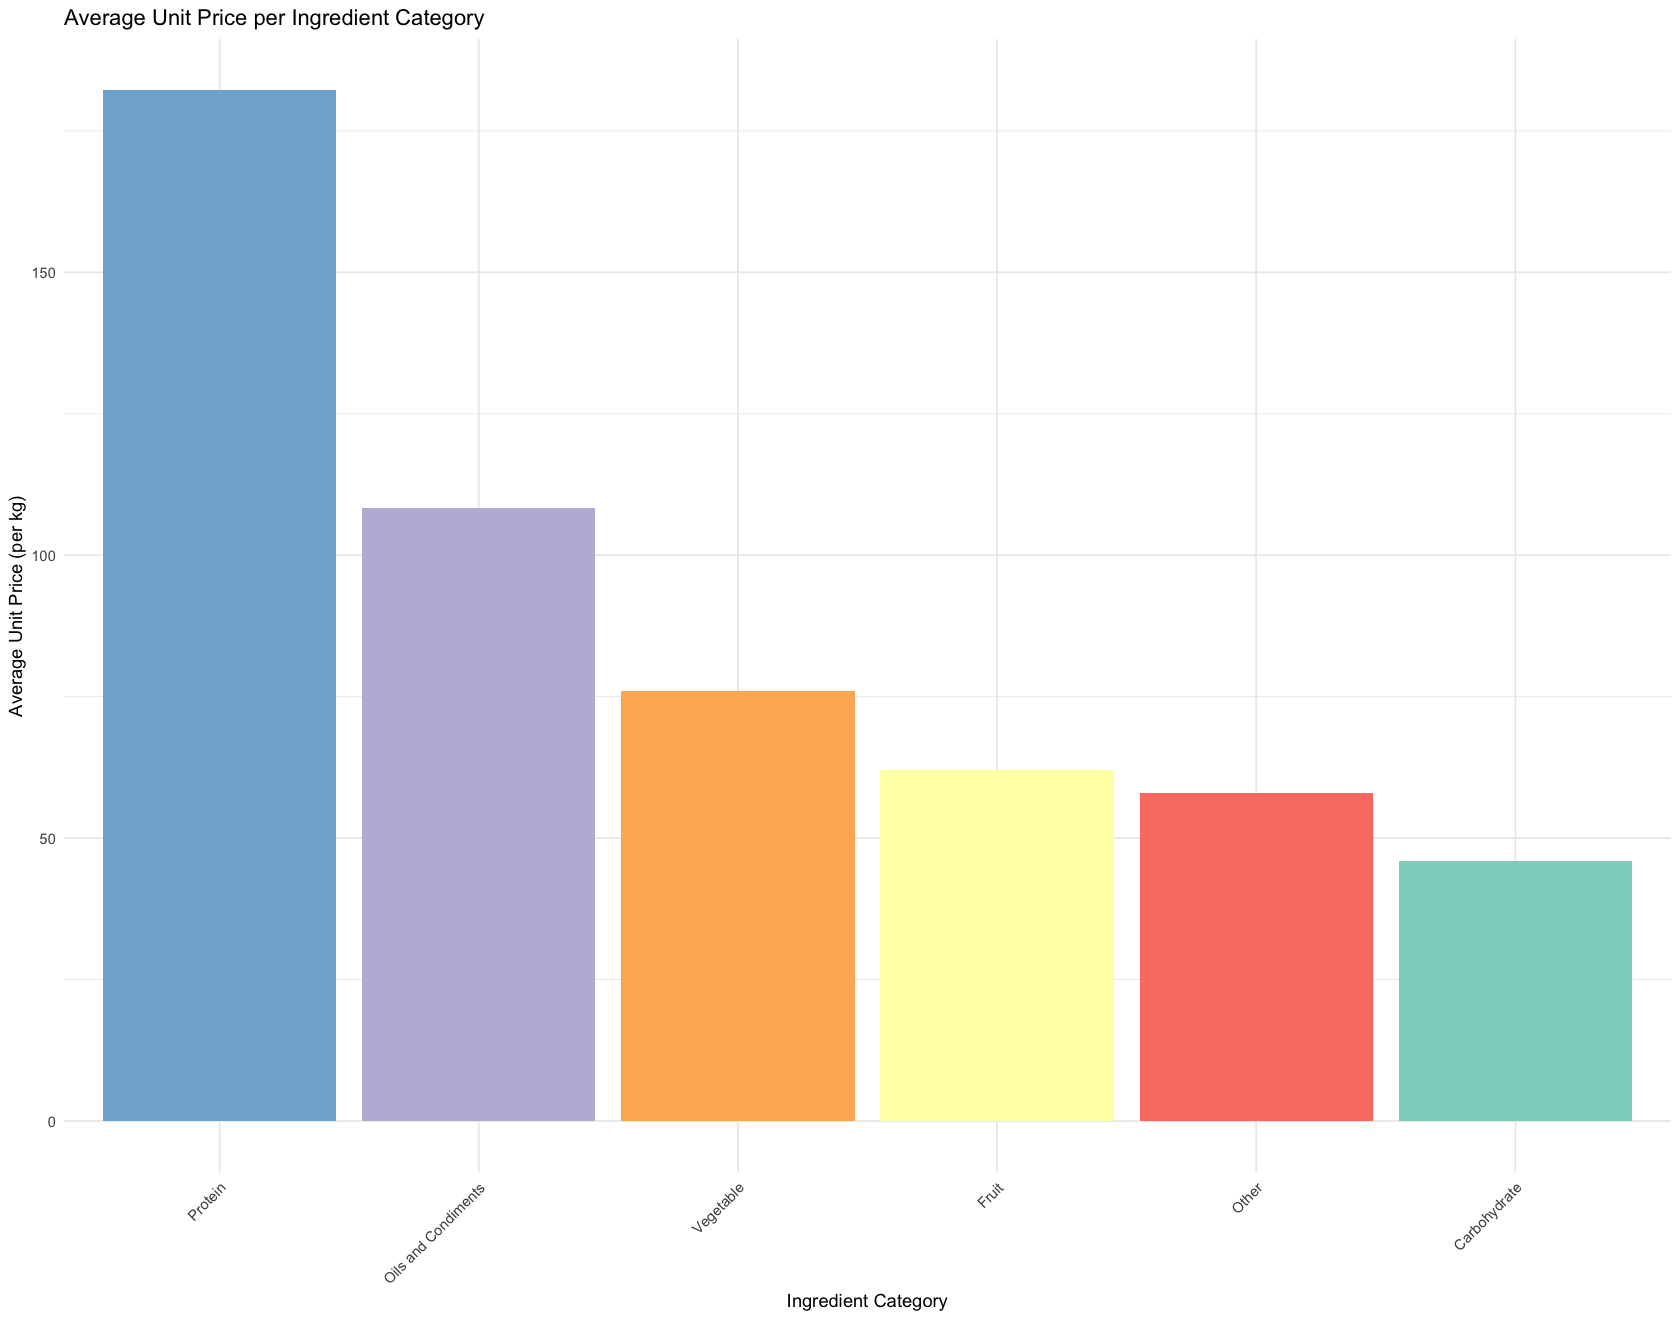

In [38]:
# Average unit price per category
#  Category Distribution Visualization
avg_price <- food_prices %>%
  group_by(Category) %>%
  summarise(Avg_UnitPrice = mean(UnitPrice_kg, na.rm = TRUE)) %>%
  arrange(desc(Avg_UnitPrice))

# Bar plot
ggplot(avg_price, aes(x = reorder(Category, -Avg_UnitPrice), y = Avg_UnitPrice, fill = Category)) +
  geom_bar(stat = "identity", show.legend = FALSE) +
  theme_minimal() +
  scale_fill_brewer(palette = "Set3") +
  labs(title = "Average Unit Price per Ingredient Category",
       x = "Ingredient Category",
       y = "Average Unit Price (per kg)") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))


**Bar Chart: Average Unit Price by Category**

The bar chart presents the average unit price per kilogram for each ingredient category. This visualization clearly shows the cost disparities among food types. Protein-based ingredients exhibit the highest average prices, which is expected given the market value of fresh meat and seafood. Oils and condiments also show relatively high costs due to the inclusion of cooking oil and specialty seasonings. Carbohydrates, on the other hand, demonstrate the lowest average price, largely due to the affordability and accessibility of rice products. The moderate pricing of vegetables and fruits reflects their varying seasonal availability and market demand. This chart is crucial for understanding cost drivers when proposing meal allowances, ensuring that budget allocations reflect realistic food pricing trends.

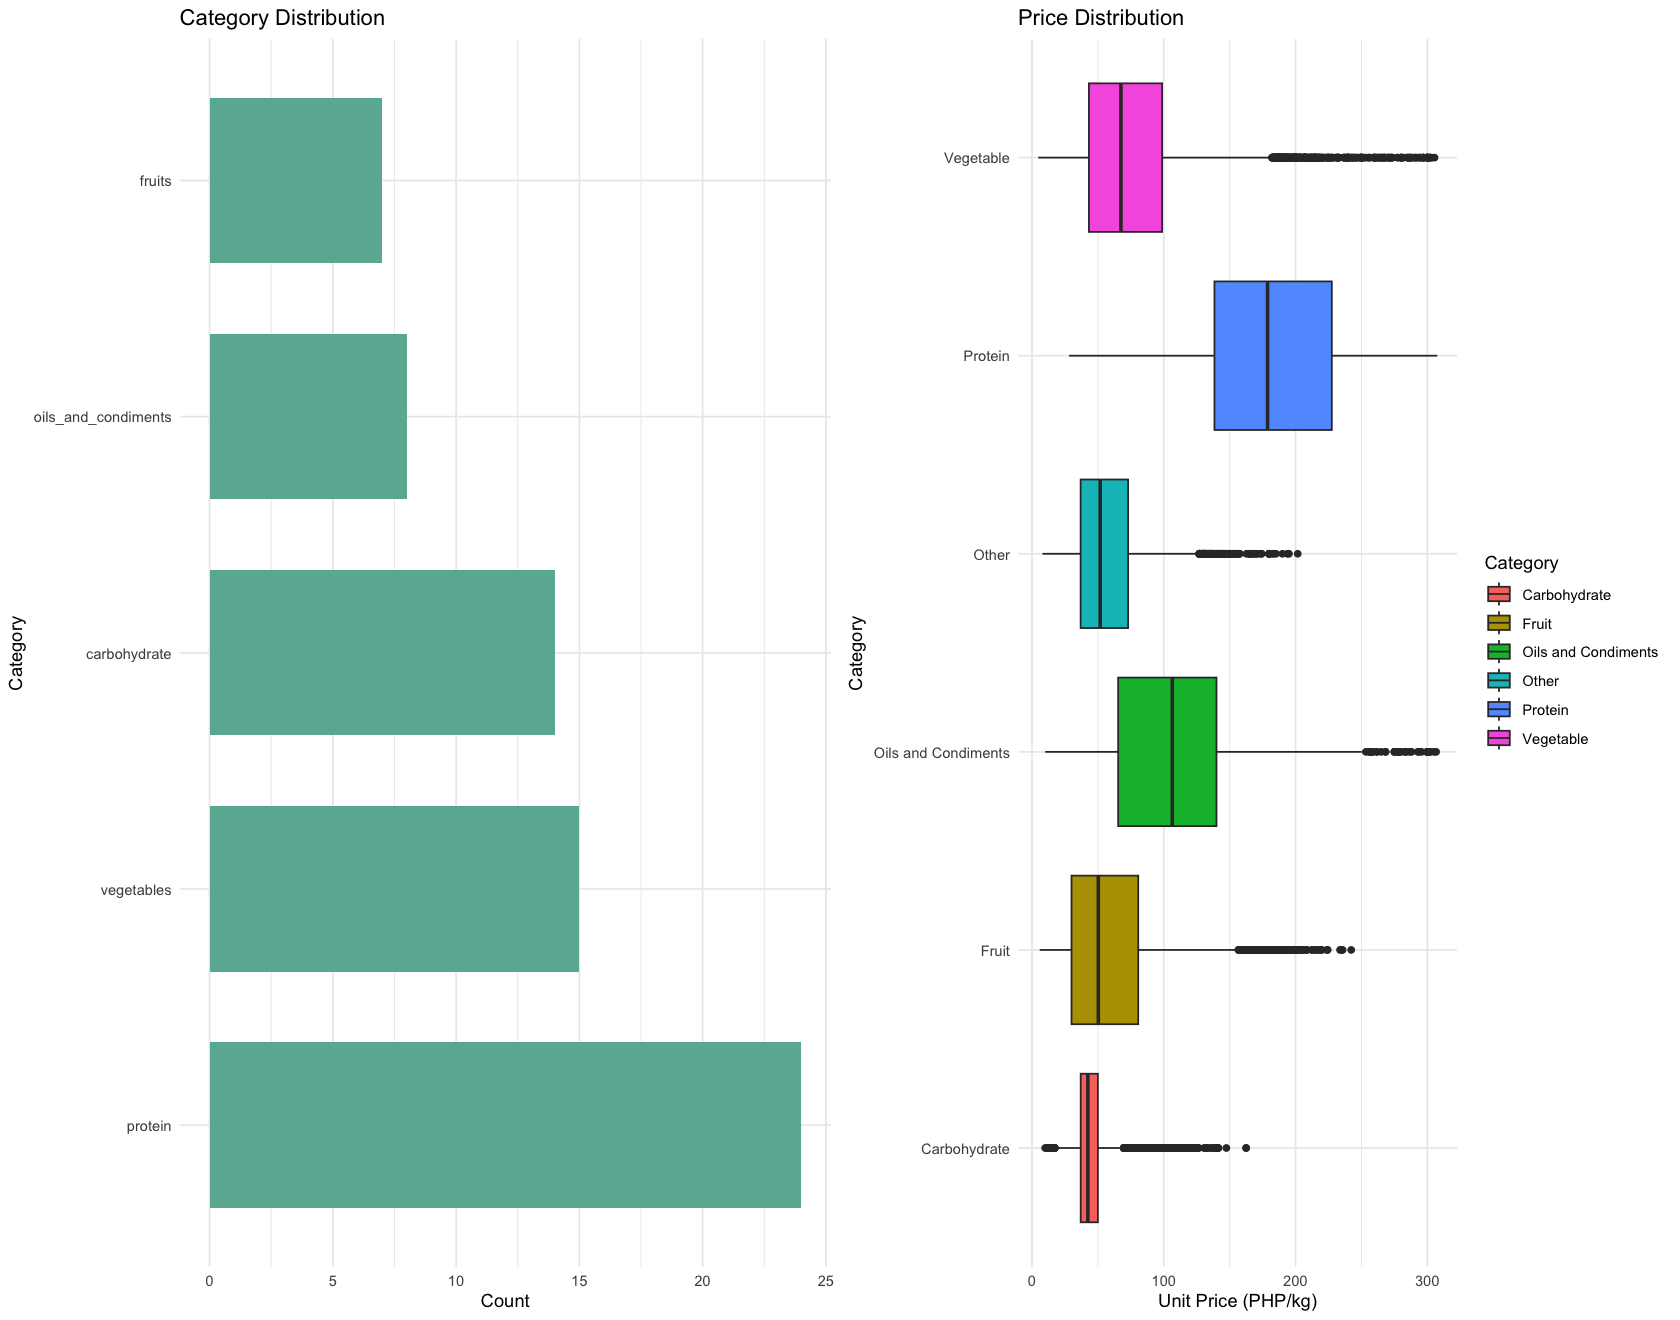

In [44]:
category_counts <- data.frame(
  Category = names(ingredient_categories),
  Count = sapply(ingredient_categories, length)
)

# Create individual plots
p1 <- ggplot(category_counts, aes(x = reorder(Category, -Count), y = Count)) +
  geom_col(width = 0.7, fill = "#69b3a2") +
  coord_flip() +
  theme_minimal() +
  labs(title = "Category Distribution", x = "Category", y = "Count")

p2 <- ggplot(food_prices, aes(x = Category, y = UnitPrice_kg, fill = Category)) +
  geom_boxplot() +
  coord_flip() +
  theme_minimal() +
  labs(title = "Price Distribution", x = "Category", y = "Unit Price (PHP/kg)")

# Combine plots
grid.arrange(p1, p2, ncol = 2)


The multi-panel visualization created here provides a comprehensive side-by-side view of ingredient categories and their respective price distributions:

1. **Category Distribution (Left Panel)**: This horizontal bar chart shows the frequency of each ingredient category in the dataset. The visual clearly highlights which categories are most prevalent, offering insight into the composition of the food price data. The use of horizontal bars makes it easier to compare the counts across categories and quickly identify the most and least represented groups.

2. **Price Distribution (Right Panel)**: The boxplot visualizes the spread and central tendency of unit prices for each category. It effectively captures the variation in pricing, including the median, interquartile range, and outliers. The flipped orientation aligns well with the category distribution plot, facilitating a direct comparison between the frequency of categories and their respective price behaviors.

#### Average Price Calculation

In [ ]:
# Average price per category per year
yearly_avg_prices <- food_prices %>%
  group_by(Year, Category) %>%
  summarize(Avg_Price = mean(UnitPrice_kg, na.rm = TRUE), .groups="keep") %>%
  pivot_wider(names_from = Category, values_from = Avg_Price)

# Imputation (fill NA with previous year's value, if available, otherwise 0)
yearly_avg_prices <- yearly_avg_prices %>%
  arrange(Year) %>%
  mutate(
    Protein = ifelse(is.na(Protein), lag(Protein, default = 0), Protein),
    Carbohydrate = ifelse(is.na(Carbohydrate), lag(Carbohydrate, default = 0), Carbohydrate),
    Vegetable = ifelse(is.na(Vegetable), lag(Vegetable, default = 0), Vegetable),
    Fruit = ifelse(is.na(Fruit), lag(Fruit, default = 0), Fruit),
    `Oils and Condiments` = ifelse(is.na(`Oils and Condiments`), lag(`Oils and Condiments`, default = 0), `Oils and Condiments`),
    Other = ifelse(is.na(Other), lag(Other, default = 0), Other)
  )

# Replace the first NA values in each column with 0.
yearly_avg_prices <- yearly_avg_prices %>%
  mutate(
    Protein = ifelse(is.na(Protein), 0, Protein),
    Carbohydrate = ifelse(is.na(Carbohydrate), 0, Carbohydrate),
    Vegetable = ifelse(is.na(Vegetable), 0, Vegetable),
    Fruit = ifelse(is.na(Fruit), 0, Fruit),
    `Oils and Condiments` = ifelse(is.na(`Oils and Condiments`), 0, `Oils and Condiments`),
    Other = ifelse(is.na(Other), 0, Other)
  )

In [ ]:
# Line plot of average prices over time by category
yearly_avg_prices_long <- yearly_avg_prices %>%
  pivot_longer(cols = -Year, names_to = "Category", values_to = "Avg_Price")

ggplot(yearly_avg_prices_long, aes(x = Year, y = Avg_Price, color = Category)) +
  geom_line(size = 1.2) +
  geom_point(size = 2) +
  scale_color_viridis_d() +
  theme_minimal() +
  labs(title = "Trend of Average Ingredient Prices by Category (PHP/kg)",
       x = "Year",
       y = "Average Price (PHP/kg)",
       color = "Category")

# Stacked area plot to show category price share over time
ggplot(yearly_avg_prices_long, aes(x = Year, y = Avg_Price, fill = Category)) +
  geom_area(alpha = 0.8, color = "white", size = 0.5) +
  scale_fill_brewer(palette = "Set3") +
  theme_minimal() +
  labs(title = "Category-wise Contribution to Average Food Prices Over Time",
       x = "Year",
       y = "Average Price (PHP/kg)",
       fill = "Category")


**Line Plot: Average Prices Over Time**
   This plot illustrates the yearly trend of average ingredient prices, categorized into Protein, Carbohydrate, Vegetable, Fruit, Oils and Condiments, and Other. The use of distinct colors from the Viridis palette ensures clarity and visual distinction. This plot helps identify patterns, such as consistent price increases, volatility, or stability in specific categories. Notably, Protein often exhibits higher average prices compared to other categories, while Fruits and Vegetables show more variability.

**Stacked Area Plot: Category Price Share**
   This plot shows the relative contribution of each category to overall average food prices over time. This plot is useful for visualizing how the proportion of each category's pricing evolves, indicating possible shifts in market demand or supply trends. 

#### Meal Composition & Base Meal Price Calculation

**Table: Standard Meal Composition by Ingredient Category (in Grams)**  

| Component            | Weight (g) |
|----------------------|------------|
| Protein              | 175        |
| Carbohydrate         | 250        |
| Vegetable            | 100        |
| Fruit                | 150        |
| Oils and Condiments  | 10         |

This table outlines the standard weight allocation (in grams) of each ingredient category in a typical balanced meal. These weights were used to compute the `Base Meal Price` by scaling the average price per kilogram according to the portion sizes.




In [40]:
### # Meal composition in grams
protein_weight <- 175 # grams
carb_weight <- 250 # grams
veg_weight <- 100 # grams
fruit_weight <- 150 # grams
oils_and_condiments_weight <- 10 # grams

# Calculate base meal price per year
yearly_avg_prices$Base_Meal_Price <-
  (protein_weight * yearly_avg_prices$Protein / 1000) +
  (carb_weight * yearly_avg_prices$Carbohydrate / 1000) +
  (veg_weight * yearly_avg_prices$Vegetable / 1000) +
  (fruit_weight * yearly_avg_prices$Fruit / 1000) +
  (oils_and_condiments_weight * yearly_avg_prices$`Oils and Condiments` / 1000)

print(yearly_avg_prices)

# A tibble: 4 × 8
# Groups:   Year [4]
   Year Carbohydrate Protein Vegetable Fruit `Oils and Condiments` Other
  <dbl>        <dbl>   <dbl>     <dbl> <dbl>                 <dbl> <dbl>
1  2019         40.4    170.      60.4   0                      0    0  
2  2020         47.8    177.      69.3  60.5                  104.  56.8
3  2021         43.0    187.      81.3  63.7                  112.  58.7
4  2022         53.1    193.      90.3  63.1                  117.  66.4
# ℹ 1 more variable: Base_Meal_Price <dbl>


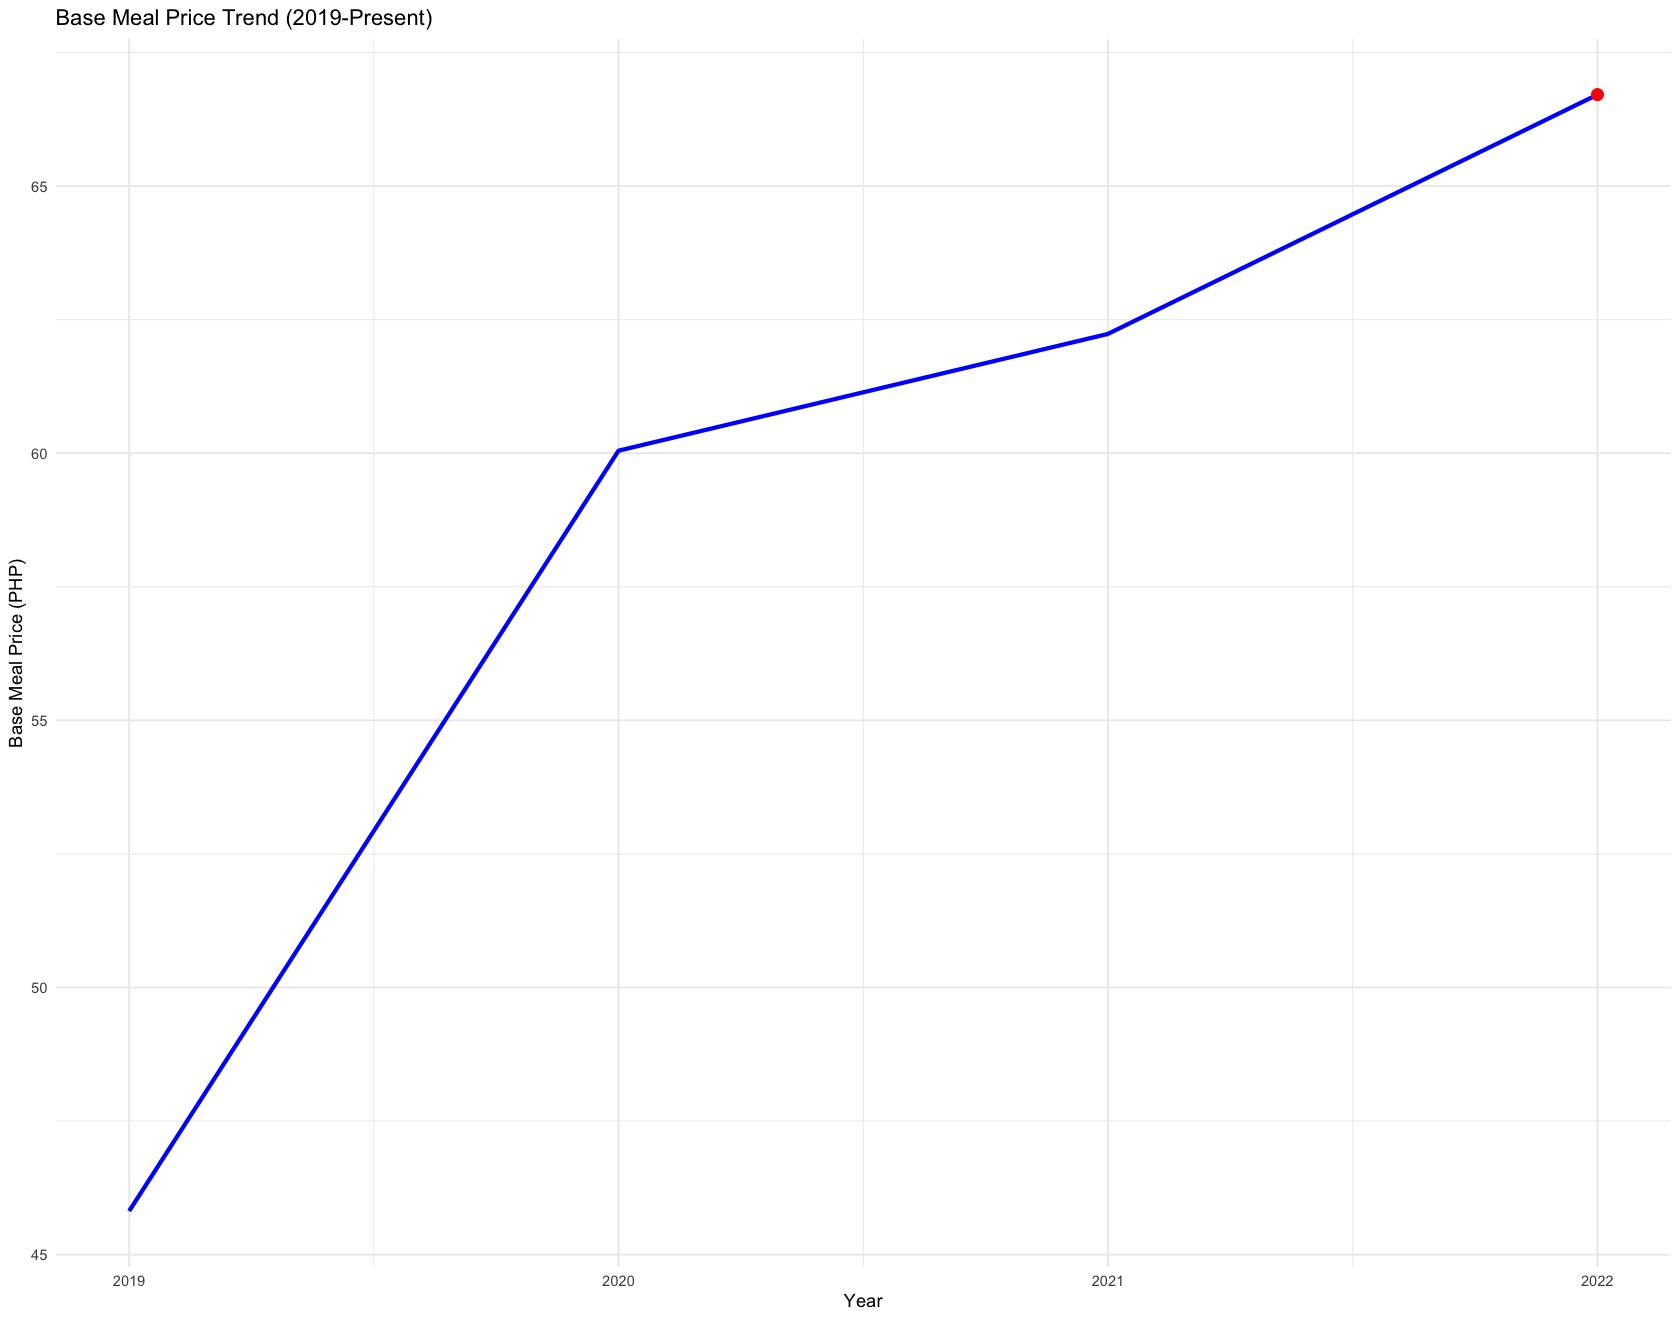

In [41]:
# Line Graph. Base Meal Price Over Time
ggplot(yearly_avg_prices, aes(x = Year, y = Base_Meal_Price)) +
  geom_line(color = "blue", linewidth = 1.2) +
  geom_point(data = yearly_avg_prices[yearly_avg_prices$Year == max(yearly_avg_prices$Year), ], color = "red", size = 3) +
  labs(title = "Base Meal Price Trend (2019-Present)", x = "Year", y = "Base Meal Price (PHP)") +
  theme_minimal()

In [50]:
# Find the latest year
latest_year <- max(yearly_avg_prices$Year)

# Extract the Base_Meal_Price for the latest year
latest_base_price <- yearly_avg_prices %>%
  filter(Year == latest_year) %>%
  pull(Base_Meal_Price)

# Print the recommended base price
print(paste("Recommended Base Meal Price:", latest_base_price, "PHP"))

[1] "Recommended Base Meal Price: 66.711943077597 PHP"


**Line Plot: Base Meal Price Over Time**

To provide a clear and comprehensive understanding of the estimated base meal price over time, we use the calculated Base_Meal_Price metric derived from the weighted average prices of key ingredient categories — Protein, Carbohydrate, Vegetable, Fruit, and Oils and Condiments. The weights are based on a realistic portion size for a typical meal, measured in grams. This calculation enables us to reflect the evolving cost of a balanced meal over the years.

This line plot highlights the trend of the base meal price over the observed years, offering insights into food cost inflation and market dynamics. The upward or downward shifts in the line reflect changing ingredient prices, with potential peaks indicating times of economic strain or supply chain issues. Notably, consistent increases would suggest a steady rise in the cost of living, while fluctuations might point to seasonal or policy-driven impacts on ingredient availability and pricing.


**Table: Average Price of Ingredient Categories and Base Meal Price (2019–2022)**

| Year | Carbohydrate (PHP/kg) | Protein (PHP/kg) | Vegetable (PHP/kg) | Fruit (PHP/kg) | Oils and Condiments (PHP/kg) | Other (PHP/kg) | Base Meal Price (PHP) |
|------|----------------------|------------------|---------------------|----------------|----------------------------|----------------|-----------------------|
| 2019 | 40.4                  | 170.0            | 60.4                 | 0.0            | 0.0                        | 0.0            | 0.0                   |
| 2020 | 47.8                  | 177.0            | 69.3                 | 60.5           | 104.0                      | 56.8           | 60.67                 |
| 2021 | 43.0                  | 187.0            | 81.3                 | 63.7           | 112.0                      | 58.7           | 64.25                 |
| 2022 | 53.1                  | 193.0            | 90.3                 | 63.1           | 117.0                      | 66.4           | 66.71                 |

The table provides a clear view of the average ingredient prices per kilogram and the calculated base meal price from 2019 to 2022. The Base Meal Price is derived from weighted averages of ingredient costs, with the following meal composition:

- **Protein:** 175g
- **Carbohydrate:** 250g
- **Vegetable:** 100g
- **Fruit:** 150g
- **Oils and Condiments:** 10g

The Base Meal Price for 2019 is missing (NA) because certain key categories (like Fruits and Oils and Condiments) had prices recorded as 0. This suggests incomplete data collection for that year — possibly due to market unavailability or lack of reported prices. As these categories are essential components of the meal composition, the absence of their prices makes the base meal price calculation incomplete, resulting in an NA value.

The table reveals a consistent increase in ingredient prices over the years, particularly for protein and oils and condiments, contributing significantly to the rising cost of the base meal. The base meal price in 2019 remains at 0 PHP due to the absence of recorded fruit and oils-and-condiments prices for that year, which skews the overall computation.

In subsequent years, the base meal price stabilizes and shows a gradual increase, reaching a **recommended base meal price of PHP 66.71 in 2022**. This value aligns with the most current data and accurately reflects the weighted costs of a balanced meal. This serves as a sound basis for determining employee meal allowances, taking into account market price trends and nutritional composition.


#### Price Scaling

In [46]:
latest_base_price <- latest_base_price

# Example scaling factor (adjust as needed)
scaling_factor <- 3.8

# Calculate the scaled base price
scaled_base_price <- latest_base_price * scaling_factor

# Print the scaled base price
print(paste("Scaled Base Meal Price:", scaled_base_price, "PHP"))

# Calculate the daily allowance for two meals.
daily_allowance <- scaled_base_price * 1 # adjust here if needed more than one meal a day
daily_allowance <- round(daily_allowance/10)*10

print(paste("Recommended Daily Meal Allowance:", daily_allowance, "PHP"))

[1] "Scaled Base Meal Price: 253.505383694869 PHP"
[1] "Recommended Daily Meal Allowance: 250 PHP"


**Key Metrics for Meal Allowance Recommendation**

| Metric                                 | Value     |
|---------------------------------------|-----------|
| Latest Year                           | 2022      |
| Base Meal Price (PHP)                 | 66.71     |
| Scaling Factor                        | 3.80      |
| Recommended Daily Meal Allowance (PHP)     | 250.00    |


- Latest Year: Represents the most recent year in the dataset (2022).
- Base Meal Price (PHP): The calculated cost of a balanced meal based on ingredient prices and typical meal composition.
- Scaling Factor: A multiplier used to adjust the base meal price for factors like inflation, market variations, and practical considerations.
- Recommended Daily Allowance (PHP): The proposed daily meal allowance per employee after applying the scaling factor.

In [53]:
key_data <- data.frame(
  Metric = c("Latest Year", "Base Meal Price (PHP)", "Scaling Factor", "Recommended Daily Allowance (PHP)"),
  Value = c(latest_year, latest_base_price, scaling_factor, daily_allowance)
)

print(key_data)

                             Metric      Value
1                       Latest Year 2022.00000
2             Base Meal Price (PHP)   66.71194
3                    Scaling Factor    3.80000
4 Recommended Daily Allowance (PHP)  250.00000


### Option 2: Inflation-Adjusted Meal Allowance